In [1]:
import requests
import re
import json
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import _thread
import time
import jieba
import jieba.analyse
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
from queue import Queue
import threading

PTT_URL = 'https://www.ptt.cc/bbs/HatePolitics/index.html'

In [2]:
def multi(urls):
    q_data = Queue()
    q_push = Queue()

    threads = []
    for url in urls:
        t = threading.Thread(target=crawl_article, args=(url, q_data, q_push))
        t.start()
        threads.append(t)

    for t in threads:
        t.join()

    data = []
    push = []

    for i in range(len(threads)):
        data.append((q_data.get()))
        push.extend((q_push.get()))

    return data, push

In [3]:
def crawl_comment_urls(amount=50):
    all_data = []
    comments = []
    nextPage = PTT_URL
    urls = []

    while len(urls) <= amount:
        # 對文章列表送出請求並取得列表主體
        resp = requests.get(nextPage, cookies={'over18': '1'})
        resp.encoding = 'utf-8'

        soup = BeautifulSoup(resp.text, 'html5lib')
        main_list = soup.find('div', class_='bbs-screen')

        nextPage = soup.find('div', 'btn-group btn-group-paging').find_all('a')[1]['href']
        nextPage = 'https://www.ptt.cc' + nextPage

        # 依序檢查文章列表中的 tag, 遇到分隔線就結束, 忽略這之後的文章
        for div in main_list.findChildren('div', recursive=False):

            class_name = div.attrs['class']

            # 遇到分隔線要處理的情況
            if class_name and 'r-list-sep' in class_name:
                print('Reach the last article of this page')
                break
            # 遇到目標文章
            if class_name and 'r-ent' in class_name:
                div_title = div.find('div', class_='title')
                a_title = div_title.find('a', href=True)

                # 如果文章已經被刪除，就跳過
                if not a_title:
                    continue

                article_URL = urljoin(PTT_URL, a_title['href'])
                article_title = a_title.text
                urls.append(article_URL)
                print('Parse {} - {}'.format(article_title, article_URL))

                if len(urls) > amount:
                    print(f'Stop crawling due to reaching the amount. Amount: {len(urls)}')
                    return urls

                # 呼叫上面寫好的 function 來對文章進行爬蟲
                #parse_data, parse_comment = crawl_article(article_URL)
                # parse_data = _thread.start_new_thread(crawl_article, (article_URL, ))

                # 將爬完的資料儲存
                #all_data.append(parse_data)
                #comments.extend(parse_comment)

    return urls

In [4]:
def crawl_article(url, q_data, q_push):
    response = requests.get(url, cookies={'over18': '1'})
    response.encoding = 'utf-8'

    # 假設網頁回應不是 200 OK 的話, 我們視為傳送請求失敗
    if response.status_code != 200:
        print('Error - {} is not available to access'.format(url))
        return

    # 將網頁回應的 HTML 傳入 BeautifulSoup 解析器, 方便我們根據標籤 (tag) 資訊去過濾尋找
    soup = BeautifulSoup(response.text, 'html5lib')

    # 取得文章內容主體
    main_content = soup.find(id='main-content')

    # 假如文章有屬性資料 (meta), 我們在從屬性的區塊中爬出作者 (author), 文章標題 (title), 發文日期 (date)
    metas = main_content.select('div.article-metaline')
    author = ''
    title = ''
    date = ''
    author_id = ''
    author_name = ''
    if metas:
        if metas[0].select('span.article-meta-value')[0]:
            author = metas[0].select('span.article-meta-value')[0].string
            author_separate = author.split(' ')
            author_id = author_separate[0].strip()

            if len(author_separate) > 1:
                author_name = author_separate[1].strip()[1:-1]

        if metas[1].select('span.article-meta-value')[0]:
            title = metas[1].select('span.article-meta-value')[0].string
        if metas[2].select('span.article-meta-value')[0]:
            date = metas[2].select('span.article-meta-value')[0].string

        # 從 main_content 中移除 meta 資訊（author, title, date 與其他看板資訊）
        #
        # .extract() 方法可以參考官方文件
        #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#extract
        for m in metas:
            m.extract()
        for m in main_content.select('div.article-metaline-right'):
            m.extract()

    # 取得留言區主體
    pushes = main_content.find_all('div', class_='push')
    for p in pushes:
        p.extract()

    # 假如文章中有包含「※ 發信站: 批踢踢實業坊(ptt.cc), 來自: xxx.xxx.xxx.xxx」的樣式
    # 透過 regular expression 取得 IP
    # 因為字串中包含特殊符號跟中文, 這邊建議使用 unicode 的型式 u'...'
    try:
        ip = main_content.find(text=re.compile(u'※ 發信站:'))
        ip = re.search('[0-9]*\.[0-9]*\.[0-9]*\.[0-9]*', ip).group()
    except Exception as e:
        ip = ''

    # 移除文章主體中 '※ 發信站:', '◆ From:', 空行及多餘空白 (※ = u'\u203b', ◆ = u'\u25c6')
    # 保留英數字, 中文及中文標點, 網址, 部分特殊符號
    #
    # 透過 .stripped_strings 的方式可以快速移除多餘空白並取出文字, 可參考官方文件
    #  - https://www.crummy.com/software/BeautifulSoup/bs4/doc/#strings-and-stripped-strings
    filtered = []
    for v in main_content.stripped_strings:
        # 假如字串開頭不是特殊符號或是以 '--' 開頭的, 我們都保留其文字
        if v[0] not in [u'※', u'◆'] and v[:2] not in [u'--']:
            filtered.append(v)

    # 定義一些特殊符號與全形符號的過濾器
    expr = re.compile(u'[^一-龥。；，：“”（）、？《》\s\w:/-_.?~%()]')
    for i in range(len(filtered)):
        filtered[i] = re.sub(expr, '', filtered[i])

    # 移除空白字串, 組合過濾後的文字即為文章本文 (content)
    filtered = [i for i in filtered if i]
    content = ' '.join(filtered)

    # 處理留言區
    # p 計算推文數量
    # b 計算噓文數量
    # n 計算箭頭數量
    p, b, n = 0, 0, 0
    messages = []
    for push in pushes:
        # 假如留言段落沒有 push-tag 就跳過
        if not push.find('span', 'push-tag'):
            continue

        # 過濾額外空白與換行符號
        # push_tag 判斷是推文, 箭頭還是噓文
        # push_userid 判斷留言的人是誰
        # push_content 判斷留言內容
        # push_ipdatetime 判斷留言日期時間
        push_tag = push.find('span', 'push-tag').string.strip(' \t\n\r')
        push_userid = push.find('span', 'push-userid').string.strip(' \t\n\r')
        push_content = push.find('span', 'push-content').strings
        push_content = ' '.join(push_content)[1:].strip(' \t\n\r')
        push_ipdatetime = push.find('span', 'push-ipdatetime').string.strip(' \t\n\r')

        # 整理打包留言的資訊, 並統計推噓文數量
        messages.append({
            'push_tag': push_tag,
            'push_userid': push_userid,
            'push_content': push_content,
            'push_ipdatetime': push_ipdatetime,
            'push_ipdate': push_ipdatetime.split(' ')[0].strip()
        })

        # comments.append(messages)
        if push_tag == u'推':
            p += 1
        elif push_tag == u'噓':
            b += 1
        else:
            n += 1

    # 統計推噓文
    # count 為推噓文相抵看這篇文章推文還是噓文比較多
    # all 為總共留言數量
    message_count = {'all': p + b + n, 'count': p - b, 'push': p, 'boo': b, 'neutral': n}

    # 整理文章資訊

    data = {
        'url': url,
        # 'article_author': author,
        'article_author_id': author_id,
        'article_author_name': author_name,
        'article_title': title,
        'article_date': date,
        'article_content': content,
        'ip': ip,
        'message_count': message_count
        #'messages': messages
    }

    q_data.put(data)
    q_push.put(messages)

In [5]:
def save_data(data):
    # 將爬完的資訊存成 json 檔案
    with open('parse_data.json', 'w+', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

def load_data(path):
    # 讀取之前存成 json 檔案的資訊
    with open(path, 'r', encoding='utf-8') as reader:
        data = json.load(reader)

    return data

In [6]:
def getStopWord():
    # 讀取檔案取得stopwords，讓jieba分析更有價值
    stopWords = list()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as reader:
        rows = reader.readlines()
        for row in rows:
            if len(row.strip()) > 0:
                stopWords.append(row.strip())
    return stopWords

In [7]:
def jiebaWord(content, topk=20):
    #斷詞並且統計每個詞彙出現的頻率
    
    regStr = '\s+|[0-9a-zA-Z_\{\}\(\)（）\./:~\=]+'
    regex = re.compile(regStr)
    
    jieba.set_dictionary('dict.txt.big') # 使用繁體辭庫
    jieba.load_userdict('user_dict.txt')  #自定義詞彙  
    jieba.analyse.set_stop_words('cn_stopwords.txt')
    
    stopWords = getStopWord()
    
    words = jieba.cut(content, cut_all=False)
    
    filterWords_list = [ w for w in words if w not in stopWords and not regex.match(w)]
    filterWords_str = ''.join(filterWords_list)
    
    tags = jieba.analyse.extract_tags(filterWords_str, topk)
        
    count = []
    for t in tags:
        count.append(filterWords_list.count(t))
    tagspd = pd.DataFrame([tags, count]).T
    tagspd = tagspd.rename({0:'KeyWords', 1:'Times'}, axis='columns')
    return tagspd, tags
    
def jiebaCount(data, columnName, topK = 20):
    #透過此function過濾資料，使用jiebaWord斷詞
    all_content = ''
    
    for d in data:
        all_content += d[columnName]
    
    content_pd, content_tags = jiebaWord(all_content, topK)

    return content_pd, content_tags

In [8]:
def wordcloudPTT(tags):
    text = " ".join(tags)
    font_path = 'msjh.ttc'
    font_path = 'hi.ttf'
    wordcloud = WordCloud(width=1200, height=600, max_font_size=200, max_words=200, 
                          background_color='black', font_path=font_path, colormap='Dark2').generate(text)
    plt.figure(dpi=600)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [9]:
def CollectIPInfo(inputData, author_ip, author_id, times):
    #觀察每個IP有多少人使用來發文/推文
    
    ipList = list()
    
    for ip in inputData[author_ip]:
        if not ip in ipList:
            ipList.append(ip)
    
    tempPd = pd.DataFrame(ipList)
    tempPd = tempPd.rename({0:author_ip}, axis='columns')
    
    user_id = []       # 裝每個發/推文者的id
    authorCount = []      # 裝每個ip的推/發文數或推/發文人數
    
    
    for ip in ipList:
        tempData = inputData[inputData[author_ip] == ip]
        tempList = list()
        
        #計算同一個ip，總共有幾個人使用，同id只算一次
        for identification in tempData[author_id]:
            if identification not in tempList:
                tempList.append(identification)
            
        user_id.append(';'.join(tempList))
        authorCount.append(len(tempList))
    
    tempPd[author_id] = user_id
    tempPd[times] = authorCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd

In [10]:
def CollectUserInfo(inputData, author, content, times):
    #觀察每個id發了多少文章/推了多少文章
    
    authorList = list()
    
    for person in inputData[author]:
        if not person in authorList:
            authorList.append(person)
    
    tempPd = pd.DataFrame(authorList)
    tempPd = tempPd.rename({0:author}, axis='columns')
    
    allArticles = ''
    count = 0
    user_id = []       # 裝每個發/推文者的id
    articleCount = []      # 裝每個id的推/發文數或推/發文人數
    
    
    for person in authorList:
        tempData = inputData[inputData[author] == person]
        
        # 取得同author的所有文章內容，並且計算總共發了幾篇文章
        for info in tempData[content]:
            allArticles += info + ' '
            
            if len(user_id) > count:
                user_id[count] = user_id[count] + ';' + info
            else:
                user_id.append(info)
            
        articleCount.append(len(tempData[content]))
        count += 1
    
    tempPd[content] = user_id
    tempPd[times] = articleCount
    tempPd = tempPd.sort_values(by=times, ascending=False).reset_index()
    
    return tempPd


In [11]:
import time

start = time.time()
urls = crawl_comment_urls(10)
data, comments = multi(urls)
save_data(data)
print('time difference:', time.time() - start, 'seconds')

Parse [黑特] 賴清德好爽，生活悠閒自在 - https://www.ptt.cc/bbs/HatePolitics/M.1612709661.A.A6B.html
Parse Re: [討論] 沒有蔡英文的民進黨 - https://www.ptt.cc/bbs/HatePolitics/M.1612709731.A.2B5.html
Parse Re: [討論] 沒有蔡英文的民進黨 - https://www.ptt.cc/bbs/HatePolitics/M.1612710304.A.E29.html
Parse Re: [討論] 罷免陳柏惟 沒有比較簡單吧 - https://www.ptt.cc/bbs/HatePolitics/M.1612710403.A.129.html
Parse [討論] 總統直選以來KMT應該算是沒輸過 - https://www.ptt.cc/bbs/HatePolitics/M.1612711040.A.B19.html
Parse Re: [討論] 美國為台灣作戰會不會有傷亡啊？ - https://www.ptt.cc/bbs/HatePolitics/M.1612711221.A.110.html
Parse [討論] 美國、歐盟 將要制裁 緬甸將領 - https://www.ptt.cc/bbs/HatePolitics/M.1612711356.A.AC1.html
Reach the last article of this page
Parse Re: [討論] 罷免陳柏惟 沒有比較簡單吧 - https://www.ptt.cc/bbs/HatePolitics/M.1612704043.A.DC8.html
Parse Re: [討論] 現在女生的政治傾向比較綠嗎? - https://www.ptt.cc/bbs/HatePolitics/M.1612704400.A.925.html
Parse [討論] 趙少康、柯文哲罷免喊卡 引起柯韓粉反彈了 - https://www.ptt.cc/bbs/HatePolitics/M.1612704822.A.619.html
Parse [討論] 罷免權是否是多餘的權力 - https://www.ptt.cc/bbs/HatePolitics/M.1

In [12]:
content_pd, content_tags = jiebaCount(data, 'article_content', 40) #看看發文中，最常出現的詞彙
message_pd, message_tags = jiebaCount(comments, 'push_content', 40) #看看推文中，最常出現的詞彙

Building prefix dict from /Users/GaryWu/Desktop/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.ub54ea009f7053a6e7164f33a0c3f57e9.cache
Loading model cost 2.532 seconds.
Prefix dict has been built successfully.
Building prefix dict from /Users/GaryWu/Desktop/PTT/dict.txt.big ...
Loading model from cache /var/folders/fs/x3hrptr53y98cz67jm09n4mc0000gn/T/jieba.ub54ea009f7053a6e7164f33a0c3f57e9.cache
Loading model cost 1.968 seconds.
Prefix dict has been built successfully.


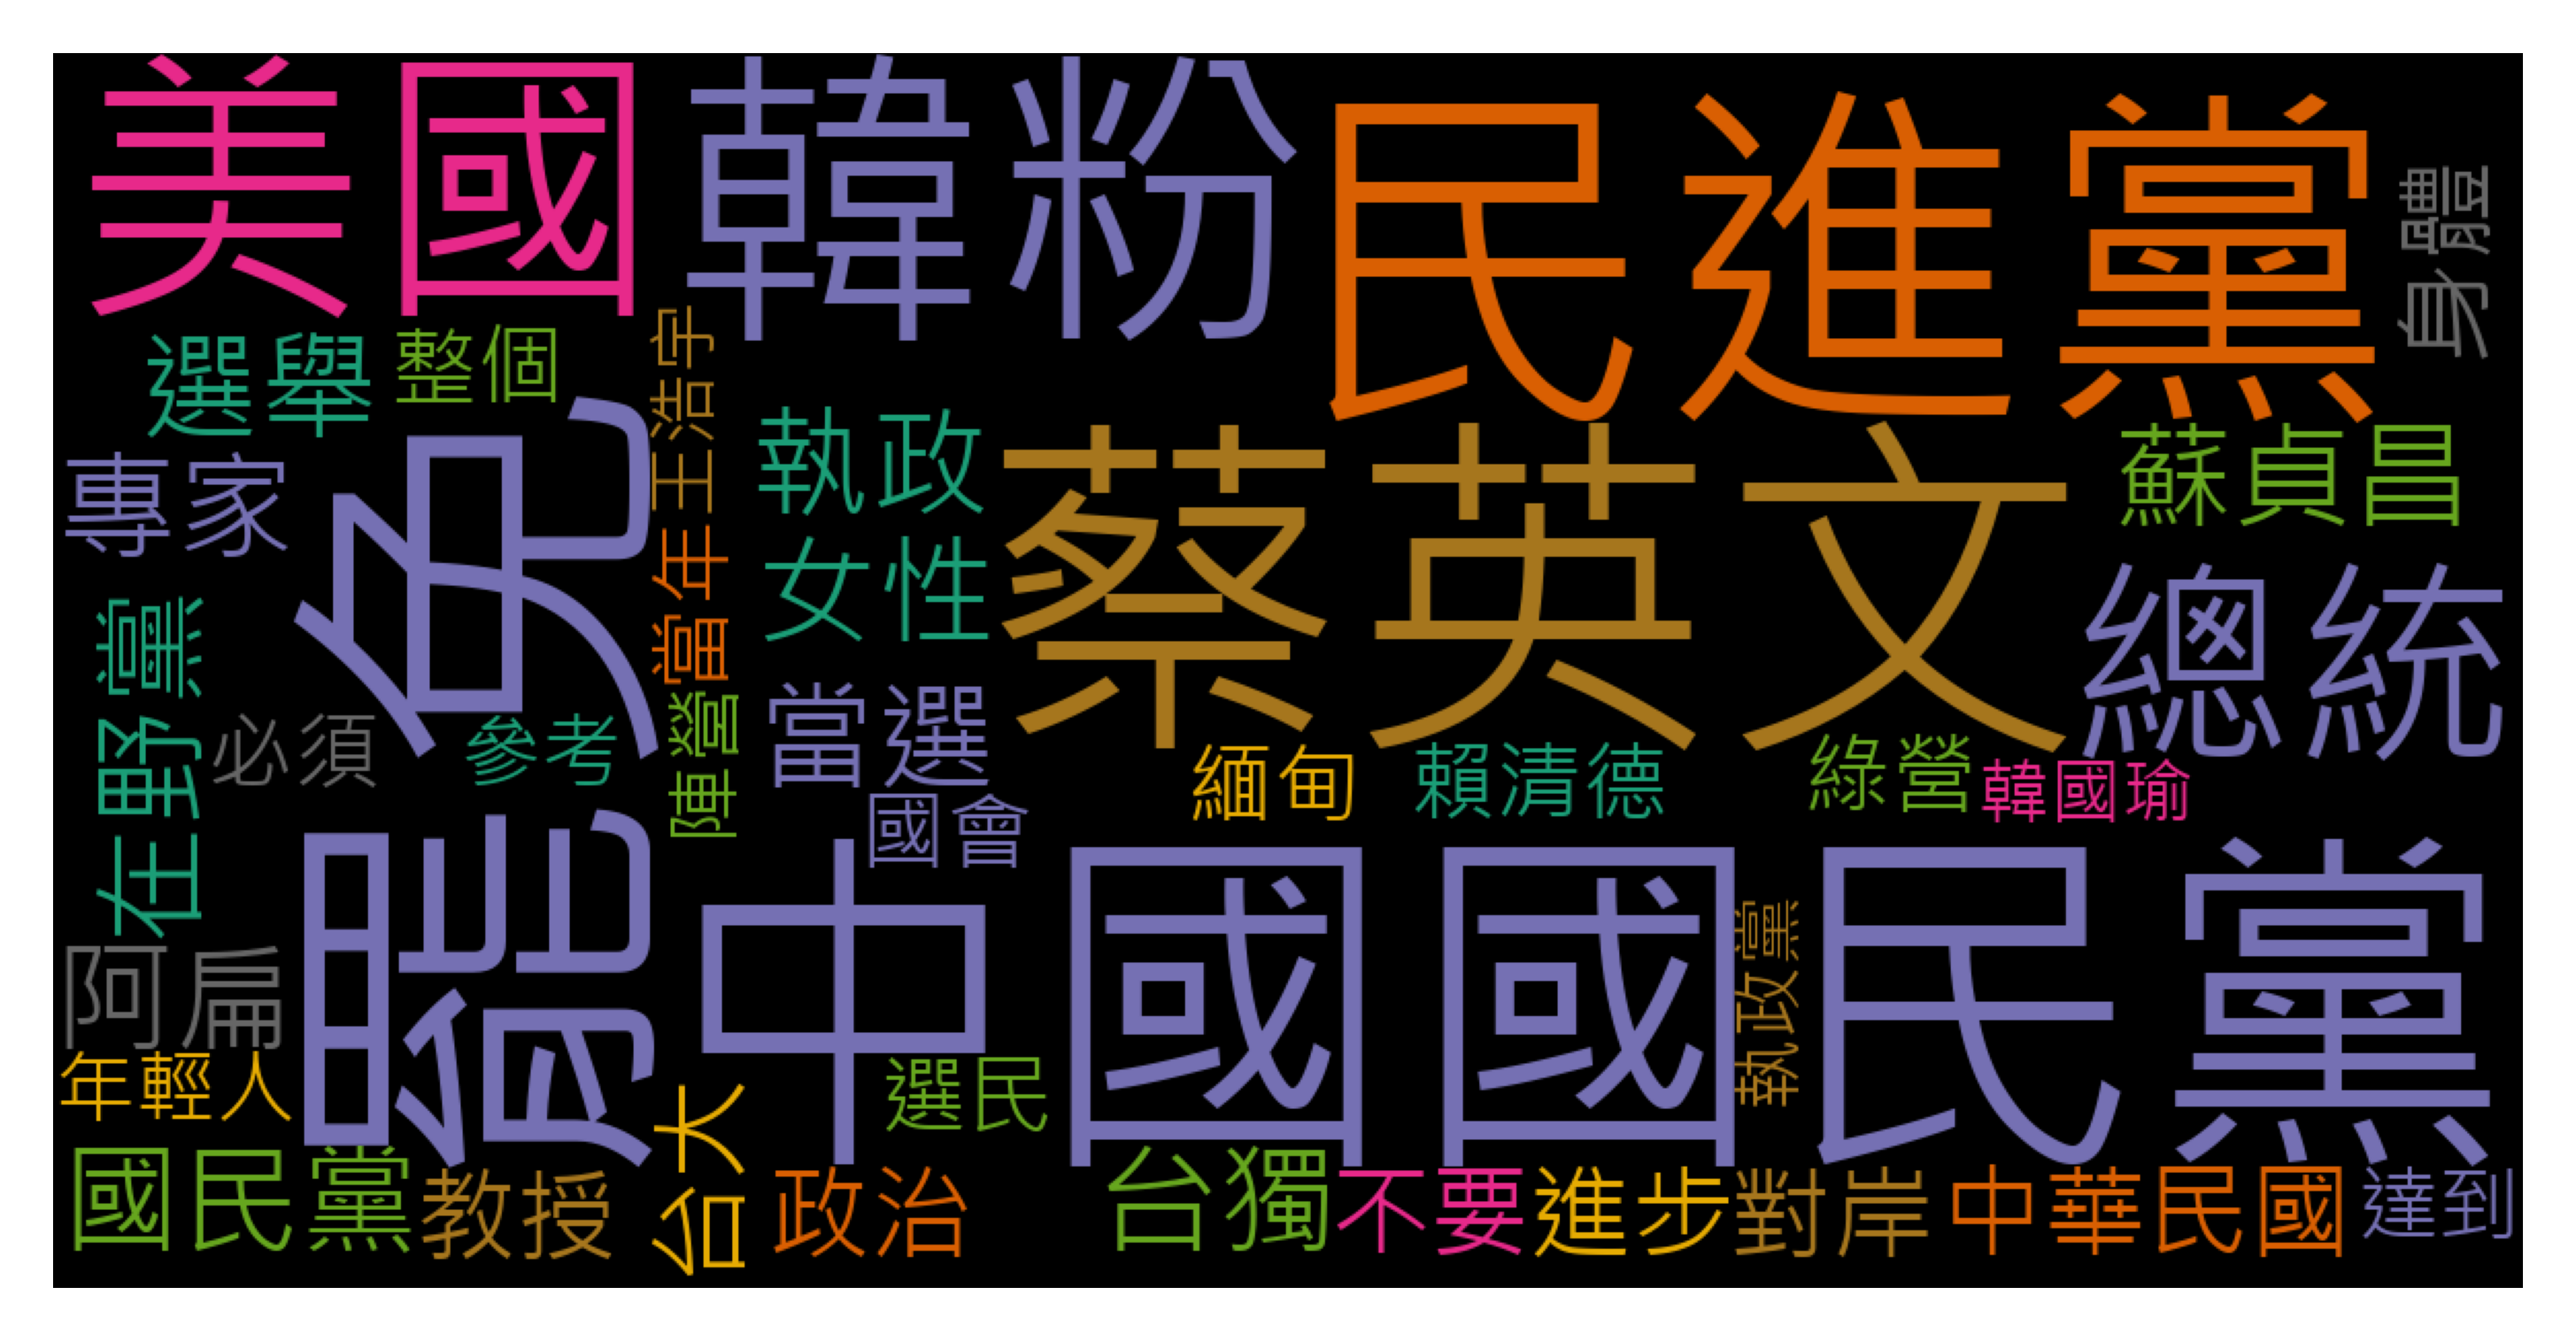

In [13]:
wordcloudPTT(content_tags) #發文的文字雲

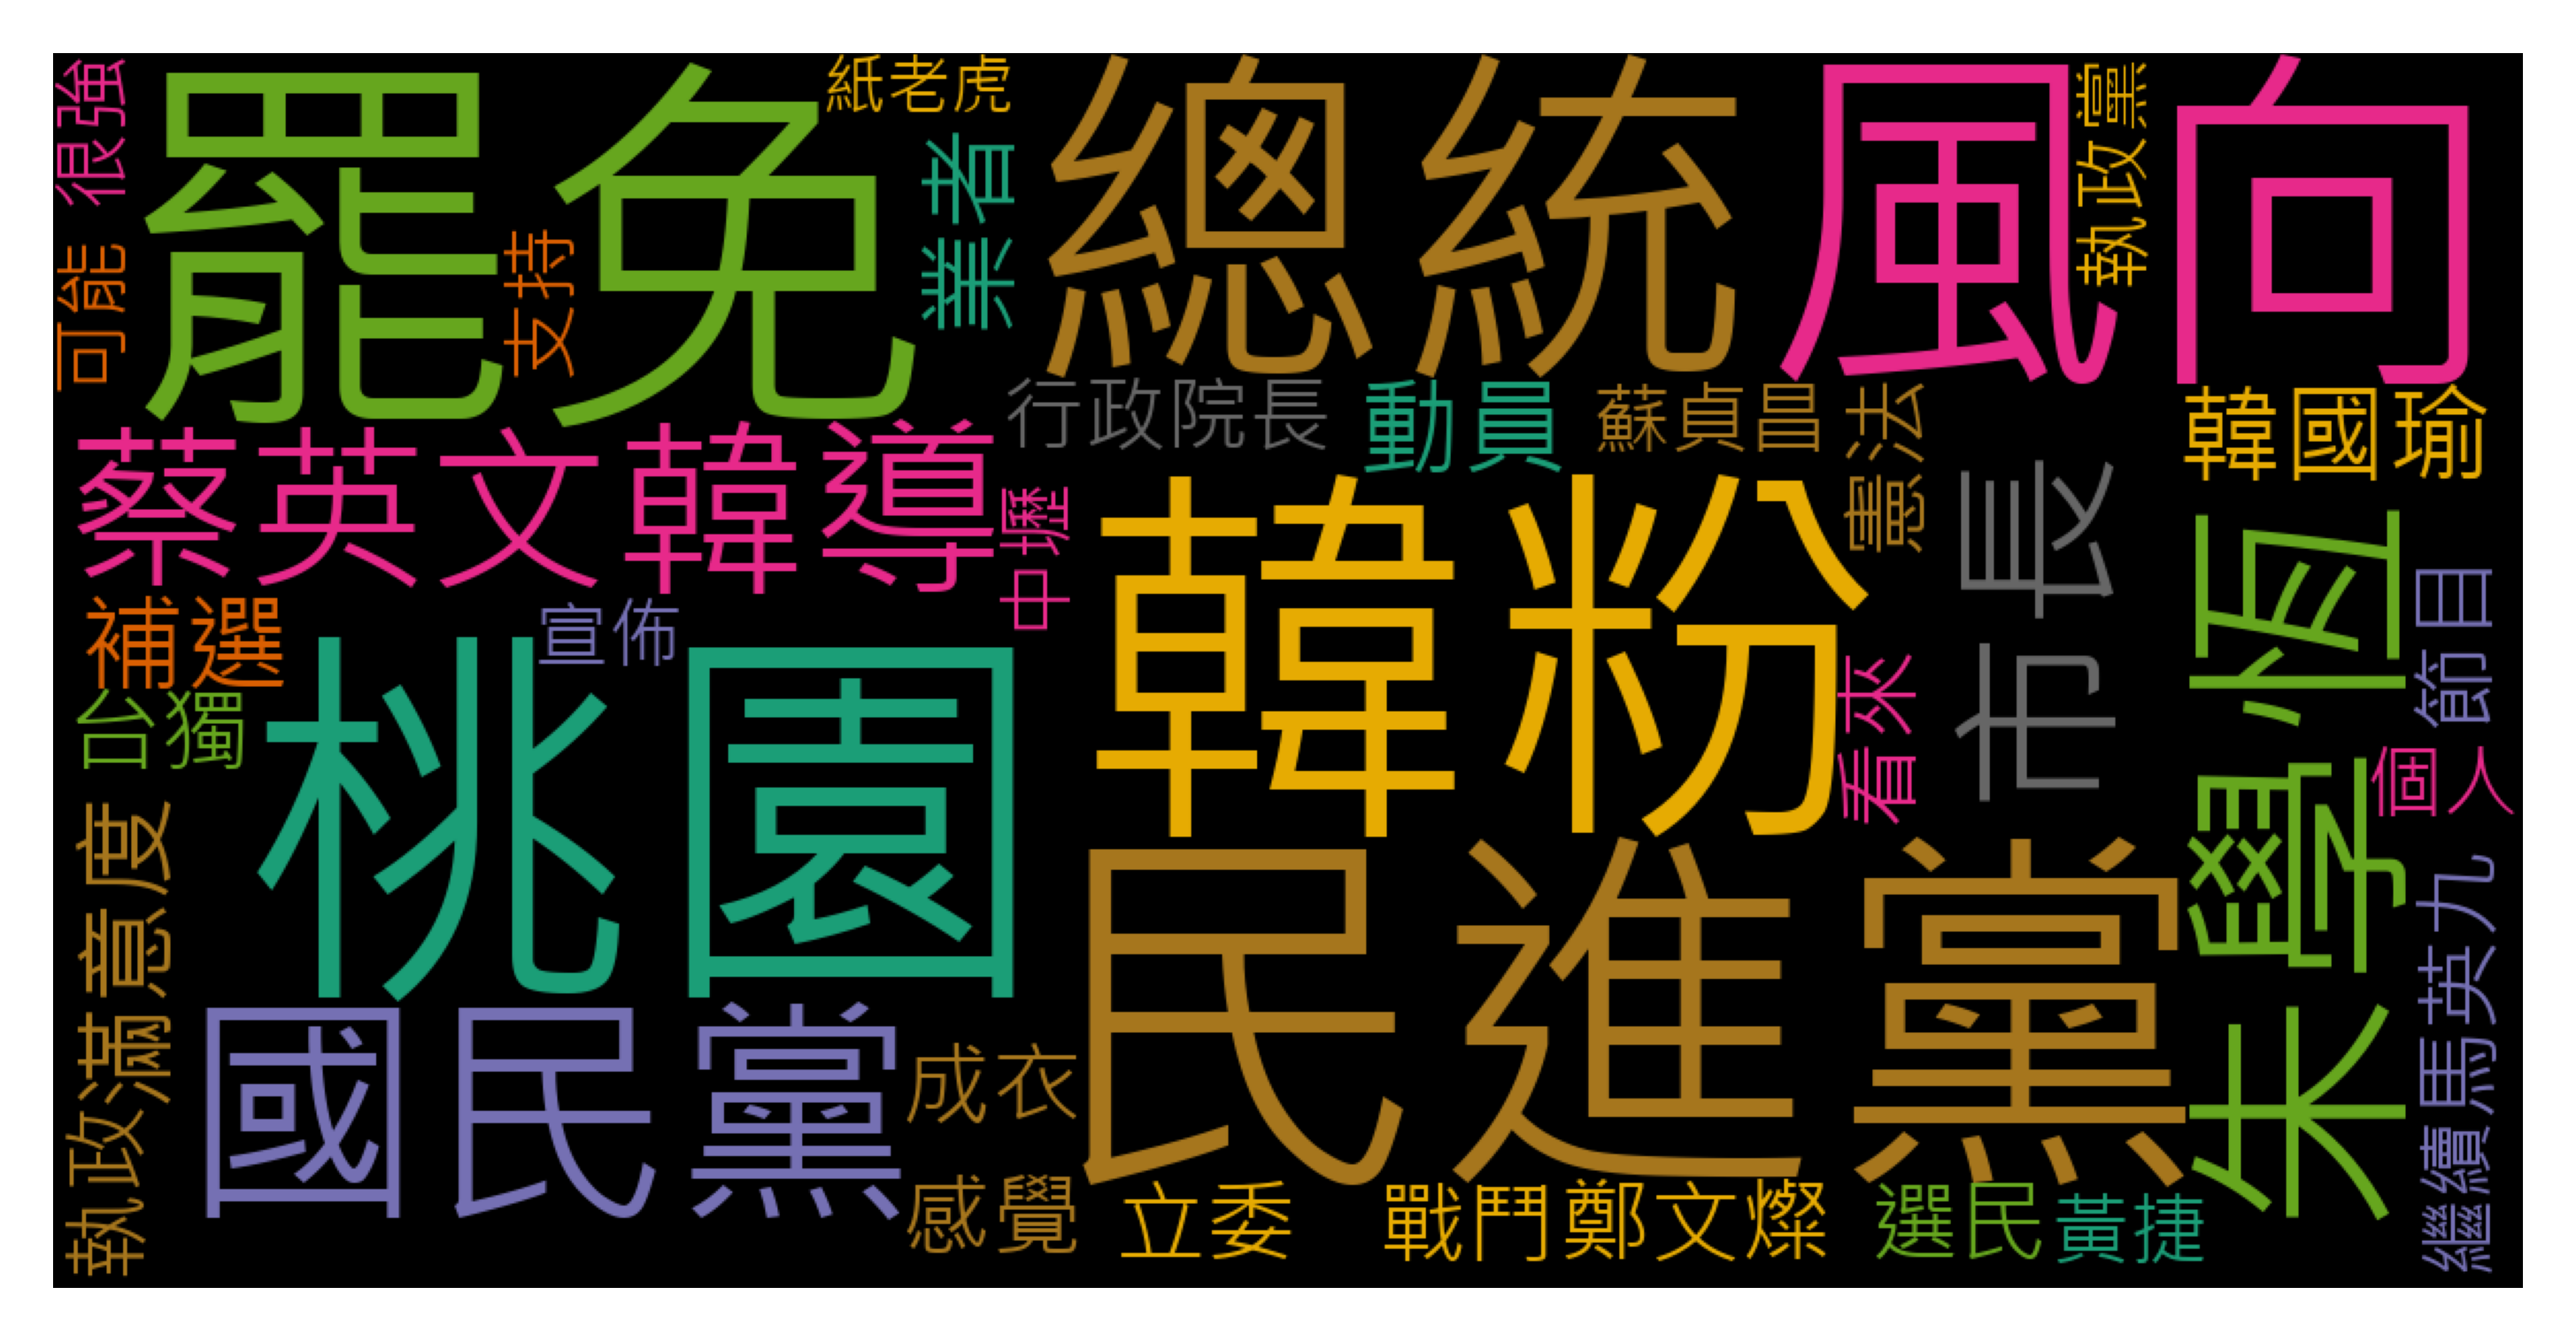

In [14]:
wordcloudPTT(message_tags) #推文的文字雲

In [15]:
content_pd.sort_values(by=['Times'], ascending = False) #發文最常出現的詞彙以及其頻率

,KeyWords,Times
0,罷免,26
1,中國國民黨,18
2,民進黨,17
3,蔡英文,13
19,政治,12
4,韓粉,11
13,女性,11
5,美國,10
24,不要,10
6,總統,9


In [16]:
message_pd.sort_values(by=['Times'], ascending = False) #推文最常出現的詞彙以及其頻率

,KeyWords,Times
0,韓粉,36
1,罷免,22
2,桃園,19
3,民進黨,17
4,風向,16
5,總統,15
6,國民黨,13
34,可能,12
7,朱學恆,10
8,韓導,8


In [17]:
pddata = pd.DataFrame(data)
pdmessage = pd.DataFrame(comments)

In [18]:
pdIdArticle = CollectUserInfo(pddata, 'article_author_id', 'article_content', 'article_times')
pdIdPush = CollectUserInfo(pdmessage, 'push_userid', 'push_content', 'push_times')

In [19]:
pdIPAuthor = CollectIPInfo(pddata, 'ip', 'article_author_id', 'author_count')
pdIPTimePush = CollectIPInfo(pdmessage, 'push_ipdatetime', 'push_userid', 'push_userid_count')
pdIPDatePush = CollectIPInfo(pdmessage, 'push_ipdate', 'push_userid', 'push_userid_count')

In [20]:
pdIdArticle

,index,article_author_id,article_content,article_times
0,0,hiball,民進黨內，\n內戰早就開打，\n52台由誰拿下，\n就是勝利者啦\n\n在政治圈的多知道，\...,1
1,1,takuminauki,: 其實這個問題 DPP必須開始思考了 : 民進黨黨內也都承認 蔡英文>>>DPP : 基本...,1
2,2,KINMENKING,歐聯下週將正式要求歐盟外交和安全政策高級代表茉格里尼擬定一份可能制裁名單，開始\n準備針對羅...,1
3,3,BleedWang,無論是陳柏惟或是黃捷\n\n師出無名 都不可能罷免的掉\n\n為什麽？？ 因為這兩隻沒有去害...,1
4,4,dusty1021,: 綠營支持者國內一直鬥國民黨也沒用 : 真的面對對岸大魔王就一點輒也沒有 : 很多人一直在...,1
5,5,Nepoleon,女性的政治，本質上就是身體界線的政治。如果不能清楚這個本質，單純以男性的角度，\n那最後都會...,1
6,6,DingLey,很多國家其實只有選沒有罷\n星日韓俄德法英加...\n還一堆都是進步國家呢\n\n我覺得說只...,1
7,7,eunhailoveu,大家晚安 大家好\n是這樣的\n\n看到標題先不要急著噓\n一堆1450這兩天一直嘲笑我們K...,1
8,8,pda2001,: 貼一些數據給大家參考 : 以韓國瑜2020的得票數為參考值 : 韓粉的動員率必須達到87...,1
9,9,brella,剛剛看了賴清德的臉書，真他媽爽，\n拜訪了臺灣導盲犬協會，看著戴著口\n罩的賴清德，仔細關心...,1
